# Estimating poly(A) tail length with Nanopolish polyA

Code for producing Figures 2 and S2 on poly(A) tail length in Arabidopsis and ERCC reads

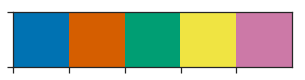

In [3]:
import sys
import os
from glob import glob
import random
from collections import Counter

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib_venn as vn
from matplotlib.colors import ListedColormap
import seaborn as sns

import pysam

## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=1.5, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [77]:
polya_lengths = {}

for fn in [x for x in glob('../*Col0*/polya_tails/*_col0_*_polya_lengths.tsv.gz') if 'ERCC' not in x]:
    sample = os.path.split(fn)[1].split('_polya_')[0]
    p = pd.read_table(
        fn, sep='\t',
        usecols=['readname', 'contig', 'position', 'polya_length', 'qc_tag'],
        na_values=['-1'],
        dtype={'readname': str, 'contig': str, 'position': int, 'polya_length': float, 'qc_tag': 'category'},
        index_col='readname'
    )
    #p = p[p['qc_tag'] == 'PASS']
    polya_lengths[sample] = p
polya_lengths = pd.concat(polya_lengths, axis=0)
polya_lengths.head()

contig  position  \
                 readname                                                
201901_col0_2916 838eac53-279a-4687-b4f8-e60824bb349f      1     30710   
                 b15e3bf9-4848-4977-9372-c4fdb848b3ec      1     30255   
                 84ba92fc-e607-46f3-a020-10114a13273b      1      6874   
                 e80d07de-8ac4-4793-b0e4-5ffb4f3071f2      1      6758   
                 0aea8df7-e207-44f8-bcc9-45ca998a8273      1      6877   

                                                       polya_length  \
                 readname                                             
201901_col0_2916 838eac53-279a-4687-b4f8-e60824bb349f           NaN   
                 b15e3bf9-4848-4977-9372-c4fdb848b3ec        198.31   
                 84ba92fc-e607-46f3-a020-10114a13273b        148.81   
                 e80d07de-8ac4-4793-b0e4-5ffb4f3071f2        162.24   
                 0aea8df7-e207-44f8-bcc9-45ca998a8273         93.84   

                                                                 qc_tag  
                 readname                                                
201901_col0_2916 838eac53-279a-4687-b4f8-e60824bb349f  READ_FAILED_LOAD  
                 b15e3bf9-4848-4977-9372-c4fdb848b3ec           ADAPTER  
                 84ba92fc-e607-46f3-a020-10114a13273b              PASS  
                 e80d07de-8ac4-4793-b0e4-5ffb4f3071f2           ADAPTER  
                 0aea8df7-e207-44f8-bcc9-45ca998a8273              PASS

In [78]:
polya_lengths.qc_tag.value_counts()

PASS                2353207
ADAPTER              896884
READ_FAILED_LOAD     178375
SUFFCLIP              18121
NOREGION               9529
Name: qc_tag, dtype: int64

In [79]:
sum(polya_lengths.qc_tag == 'PASS') / len(polya_lengths)

0.6808819495641929

In [86]:
polya_lengths = polya_lengths[polya_lengths['qc_tag'] == 'PASS']

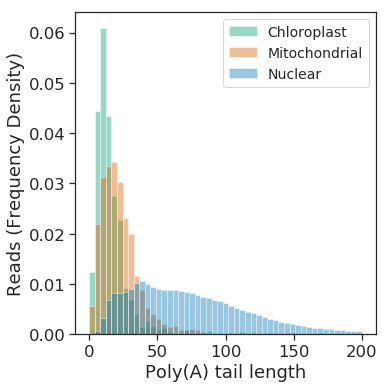

In [87]:
fig, ax = plt.subplots(figsize=(5.5, 5.5))
mt = polya_lengths[polya_lengths.contig == 'Mt']
pt = polya_lengths[polya_lengths.contig == 'Pt']
nc = polya_lengths[~polya_lengths.contig.isin(['Mt', 'Pt'])]
sns.distplot(pt.dropna().polya_length,
             hist=True, kde=False,
             bins=np.linspace(0, 200, 50),
             hist_kws={'density': True},
             color=pal[2],
             label='Chloroplast')
sns.distplot(mt.dropna().polya_length,
             hist=True, kde=False,
             bins=np.linspace(0, 200, 50),
             hist_kws={'density': True},
             color=pal[1],
             label='Mitochondrial')
sns.distplot(nc.dropna().polya_length,
             hist=True, kde=False,
             bins=np.linspace(0, 200, 50),
             hist_kws={'density': True},
             color=pal[0],
             label='Nuclear')
ax.set_xlabel('Poly(A) tail length')
ax.set_ylabel('Reads (Frequency Density)')
#ax.set_xticks([0, 1, 2, 3])
#ax.set_xticklabels([1, 10, 100, 1000])
#ax.set_xlim(-1, 2.75)
ax.legend(fontsize=14)
plt.tight_layout()
plt.savefig('polya_tail_length_dist.svg', transparent=True)
plt.show()

In [88]:
nc.polya_length.describe(percentiles=(0.025, 0.25, 0.50, 0.75, 0.975))

count    2.348869e+06
mean     7.740739e+01
std      5.153365e+01
min      0.000000e+00
2.5%     1.379000e+01
25%      3.983000e+01
50%      6.786000e+01
75%      1.028500e+02
97.5%    2.002900e+02
max      2.150330e+03
Name: polya_length, dtype: float64

In [84]:
pt.polya_length.describe(percentiles=(0.025, 0.25, 0.50, 0.75, 0.975))

count    1848.000000
mean       17.023723
std        18.776165
min         0.200000
2.5%        3.087000
25%         8.520000
50%        12.760000
75%        19.465000
97.5%      56.469250
max       252.730000
Name: polya_length, dtype: float64

In [85]:
mt.polya_length.describe(percentiles=(0.025, 0.25, 0.50, 0.75, 0.975))

count    2490.000000
mean       24.281570
std        24.979565
min         0.970000
2.5%        4.139000
25%        12.592500
50%        19.920000
75%        29.267500
97.5%      72.638000
max       674.550000
Name: polya_length, dtype: float64

In [62]:
ercc_polya_lengths = {}

for fn in glob('../*Col0*_ERCC/polya_tails/*_col0_*_polya_lengths.tsv.gz'):
    sample = os.path.split(fn)[1].split('_polya_')[0]
    p = pd.read_table(
        fn, sep='\t',
        usecols=['readname', 'contig', 'position', 'polya_length', 'qc_tag'],
        na_values=['-1'],
        dtype={'readname': str, 'contig': str, 'position': int, 'polya_length': float, 'qc_tag': 'category'},
        index_col='readname'
    )
    #p = p[p['qc_tag'] == 'PASS']
    ercc_polya_lengths[sample] = p
ercc_polya_lengths = pd.concat(ercc_polya_lengths, axis=0)
ercc_polya_lengths.head()

contig  position  \
                 readname                                                     
201901_col0_2916 e4d53ebe-cecf-4f52-bd73-6f3651902424  ERCC-00002         1   
                 e661ae3c-ce2d-40aa-9eb1-581920818886  ERCC-00002         2   
                 ca7ee264-3ba3-4040-93b7-2eaaf72c9f7d  ERCC-00002         0   
                 e46af28b-7f25-4ae4-b078-b233eb539b5b  ERCC-00002         2   
                 d95a83bf-83f3-4c93-abaa-2710b8365187  ERCC-00002         2   

                                                       polya_length  \
                 readname                                             
201901_col0_2916 e4d53ebe-cecf-4f52-bd73-6f3651902424           NaN   
                 e661ae3c-ce2d-40aa-9eb1-581920818886          4.23   
                 ca7ee264-3ba3-4040-93b7-2eaaf72c9f7d           NaN   
                 e46af28b-7f25-4ae4-b078-b233eb539b5b          0.07   
                 d95a83bf-83f3-4c93-abaa-2710b8365187         27.74   

                                                                 qc_tag  
                 readname                                                
201901_col0_2916 e4d53ebe-cecf-4f52-bd73-6f3651902424  READ_FAILED_LOAD  
                 e661ae3c-ce2d-40aa-9eb1-581920818886           ADAPTER  
                 ca7ee264-3ba3-4040-93b7-2eaaf72c9f7d  READ_FAILED_LOAD  
                 e46af28b-7f25-4ae4-b078-b233eb539b5b          NOREGION  
                 d95a83bf-83f3-4c93-abaa-2710b8365187              PASS

In [63]:
ercc_polya_lengths.qc_tag.value_counts()

PASS                5474
ADAPTER             2241
READ_FAILED_LOAD     941
NOREGION             185
SUFFCLIP              48
Name: qc_tag, dtype: int64

In [64]:
sum(ercc_polya_lengths.qc_tag == 'PASS') / len(ercc_polya_lengths)

0.6158173022837214

In [65]:
ercc_polya_lengths = ercc_polya_lengths[ercc_polya_lengths['qc_tag'] == 'PASS']

In [3]:
%%bash
wget https://assets.thermofisher.com/TFS-Assets/LSG/manuals/cms_095047.txt

--2019-10-21 13:11:06--  https://assets.thermofisher.com/TFS-Assets/LSG/manuals/cms_095047.txt
Resolving assets.thermofisher.com... 104.127.43.132
Connecting to assets.thermofisher.com|104.127.43.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87408 (85K) [text/plain]
Saving to: ‘cms_095047.txt.1’

     0K .......... .......... .......... .......... .......... 58%  690K 0s
    50K .......... .......... .......... .....                100% 6.93M=0.08s

2019-10-21 13:11:07 (1.08 MB/s) - ‘cms_095047.txt.1’ saved [87408/87408]



In [66]:
ercc_seqs = pd.read_csv('cms_095047.txt', sep='\t', index_col=0)
ercc_seqs['polya'] = ercc_seqs.Sequence.str.extract('(A+)$')
ercc_seqs['polya_length'] = ercc_seqs['polya'].str.len()
ercc_seqs.head()

,GenBank,5prime_assay,3prime_assay,Sequence,polya,polya_length
ERCC_ID,,,,,,
ERCC-00002,DQ459430,Ac03459872_a1,Ac03459968_a1,TCCAGATTACTTCCATTTCCGCCCAAGCTGCTCACAGTATACGGGC...,AAAAAAAAAAAAAAAAAAAAAAAA,24.0
ERCC-00003,DQ516784,Ac03459873_a1,Ac03459969_a1,CAGCAGCGATTAAGGCAGAGGCGTTTGTATCTGCCATTATAAAGAA...,AAAAAAAAAAAAAAAAAAAAAAAA,24.0
ERCC-00004,DQ516752,Ac03459874_a1,Ac03459970_a1,TCTTGCTTCAACAATAACGTCTCTTTCAGAAGGCATTGGTATCTTT...,AAAAAAAAAAAAAAAAAAAAAAAA,24.0
ERCC-00009,DQ668364,Ac03459876_a1,Ac03459972_a1,CAATGATAGGCTAGTCTCGCGCAGTACATGGTAGTTCAGCCAATAG...,AAAAAAAAAAAAAAAAAAAAAAAA,24.0
ERCC-00012,DQ883670,Ac03459877_a1,Ac03459973_a1,CGAGAGATGTTTGTAGGTGCGGAATGTGTGCGGTCTACCTTAGCTG...,AAAAAAAAAAAAAAAAAAAAAAAA,24.0


In [67]:
ercc_polya_lengths.polya_length.describe(percentiles=(0.025, 0.25, 0.50, 0.75, 0.975))

count    5474.000000
mean       35.628551
std        34.781596
min         0.350000
2.5%        7.538250
25%        20.770000
50%        26.240000
75%        36.917500
97.5%     122.350000
max       556.290000
Name: polya_length, dtype: float64

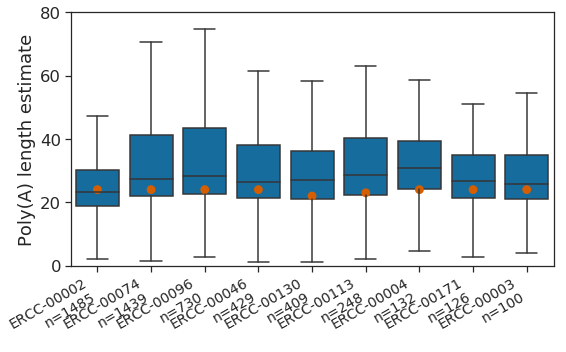

In [59]:
reads_per_contig = ercc_polya_lengths.contig.value_counts()
order = reads_per_contig[reads_per_contig >= 100].index

fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(
    x='contig',
    y='polya_length',
    data=ercc_polya_lengths,
    order=order,
    fliersize=0,
    color=pal[0],
)
sns.pointplot(
    x='ERCC_ID',
    y='polya_length',
    data=ercc_seqs.reset_index(),
    order=order,
    join=False, ci=None,
    estimator=lambda x: x[0] if len(x) == 1 else np.nan,
    color=pal[1]
)
ax.set_ylim(0, 80)
xticklabels = [f'{x.get_text()}\nn={reads_per_contig[x.get_text()]}' for x in ax.get_xticklabels()]
ax.set_xticklabels(xticklabels, rotation=30, ha='right', va='top', fontsize=14)
ax.set_xlabel('')
ax.set_ylabel('Poly(A) length estimate')
plt.tight_layout()
plt.savefig('ERCC_polya_length_boxplot.svg')
plt.savefig('ERCC_polya_length_boxplot.png')
plt.show()

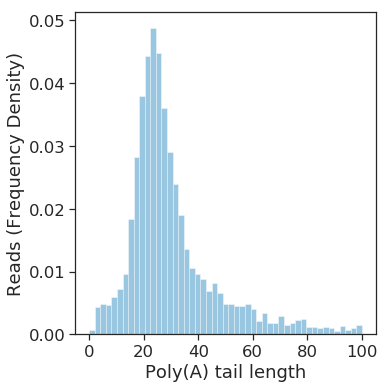

In [91]:
fig, ax = plt.subplots(figsize=(5.5, 5.5))
sns.distplot(ercc_polya_lengths.dropna().polya_length,
             hist=True, kde=False,
             bins=np.linspace(0, 100, 50),
             hist_kws={'density': True},
             color=pal[0])
ax.set_xlabel('Poly(A) tail length')
ax.set_ylabel('Reads (Frequency Density)')
#ax.set_xticks([0, 1, 2, 3])
#ax.set_xticklabels([1, 10, 100, 1000])
#ax.set_xlim(-1, 2.75)
plt.tight_layout()
plt.savefig('ERCC_polya_length.svg')
plt.savefig('ERCC_polya_length.png')
plt.show()

In [9]:
vir1_pa_dists = pd.read_csv(
    'data/vir1_vs_col0_polya.tsv',
    sep='\t',
    names=['chrom', 'start', 'end', 'gene_id',
           'score', 'strand', 'nreads_col0', 'nreads_vir1',
           'median_col0', 'ci_lower_col0', 'ci_upper_col0',
           'median_vir1', 'ci_lower_vir1', 'ci_upper_vir1',
           'ks', 'ks_p_val', 'ks_fdr',
           'mwu', 'mwu_p_val', 'mwu_fdr']
)

vir1_pa_dists['cpm_col0'] = vir1_pa_dists['nreads_col0'] / vir1_pa_dists['nreads_col0'].sum(0) * 1_000_000
vir1_pa_dists['cpm_vir1'] = vir1_pa_dists['nreads_vir1'] / vir1_pa_dists['nreads_vir1'].sum(0) * 1_000_000
vir1_pa_dists['med_change'] = vir1_pa_dists['median_vir1'] - vir1_pa_dists['median_col0']
vir1_pa_dists.head()

,chrom,start,end,gene_id,score,strand,nreads_col0,nreads_vir1,median_col0,ci_lower_col0,...,ci_upper_vir1,ks,ks_p_val,ks_fdr,mwu,mwu_p_val,mwu_fdr,cpm_col0,cpm_vir1,med_change
0,1,31169,33171,AT1G01050,0.238514,-,45,47,68.169998,15.035000,...,241.488496,0.157920,0.577412,0.961353,898.5,0.107856,0.389911,96.062300,62.509892,14.120003
1,1,33364,37871,AT1G01060,0.128895,-,12,32,68.945000,25.178000,...,186.448251,0.218750,0.743199,0.996127,182.0,0.401156,0.490438,25.616613,42.559926,12.420002
2,1,44969,47059,AT1G01080,0.021193,-,24,61,103.040001,17.694249,...,205.600006,0.120219,0.952374,1.000000,685.0,0.324926,0.476891,51.233226,81.129860,-2.629997
3,1,47233,49304,AT1G01090,0.156813,-,72,78,83.704998,34.993001,...,151.514257,0.113248,0.696927,0.994525,2721.0,0.372443,0.486337,153.699679,103.739821,2.430004
4,1,49908,51210,AT1G01100,1.955502,-,415,357,58.169998,14.009000,...,145.250006,0.115285,0.011079,0.308539,64624.0,0.001107,0.073091,885.907874,474.809179,-10.369999


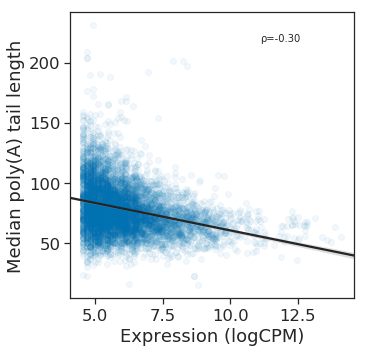

In [13]:
fig, ax = plt.subplots(figsize=(5.2, 5))
plt.tight_layout()
nuclear_only = vir1_pa_dists[vir1_pa_dists.chrom.isin(list('12345'))]

sns.regplot(
    x=np.log2(nuclear_only.cpm_col0),
    y=nuclear_only.median_col0,
    scatter_kws={'alpha': 0.05, 'rasterized': True},
    line_kws={'color': '#252525'},
    lowess=False, ax=ax
)

ax.set_xlabel('Expression (logCPM)')
ax.set_ylabel('Median poly(A) tail length')

rho, p = stats.spearmanr(nuclear_only.cpm_col0, nuclear_only.median_col0)

ax.annotate(xy=(0.67, 0.9), s=f'ρ={rho:.2f}', xycoords='axes fraction')

plt.tight_layout()
plt.savefig('polya_length_vs_expression.svg')
plt.show()

In [30]:
print(rho, p)

-0.3001785030864042 2.04240659038743e-133


In [15]:
boot_res = []

s = nuclear_only.loc[:, ['cpm_col0', 'median_col0']]
n = len(s)

for _ in range(10_000):
    samp = s.sample(n=n, replace=True)
    boot_res.append(stats.spearmanr(samp['cpm_col0'], samp['median_col0'])[0])

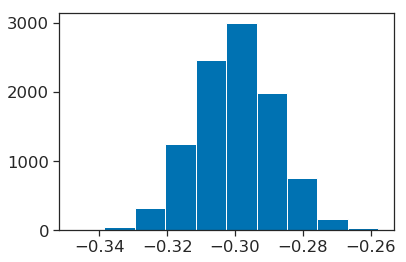

In [16]:
plt.hist(boot_res)
plt.show()

In [17]:
np.percentile(boot_res, (2.5, 97.5))

array([-0.32254137, -0.27702489])